In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import random
import argparse
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
import utils
import torch.optim.lr_scheduler as lr_scheduler


import models
import training

NUM_CLASSES = 10


### Self-Supervised MNIST

In [9]:
# MNIST TRAINING

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = models.SelfSupervised_MNIST(latent_dim=128)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoints_path = "encoder_mnist.pth"
trainer = training.SelfSupervisedTrainer(model, dl_train, dl_val, loss_fn, optimizer, device)
trainer.train(num_epochs=10, checkpoints=checkpoints_path)

Epoch [1/10], Train Loss: 0.0354, Val Loss: 0.0080
Epoch [2/10], Train Loss: 0.0057, Val Loss: 0.0044
Epoch [3/10], Train Loss: 0.0037, Val Loss: 0.0033
Epoch [4/10], Train Loss: 0.0029, Val Loss: 0.0027
Epoch [5/10], Train Loss: 0.0025, Val Loss: 0.0025
Epoch [6/10], Train Loss: 0.0022, Val Loss: 0.0021
Epoch [7/10], Train Loss: 0.0020, Val Loss: 0.0020
Epoch [8/10], Train Loss: 0.0018, Val Loss: 0.0018
Epoch [9/10], Train Loss: 0.0017, Val Loss: 0.0017
Epoch [10/10], Train Loss: 0.0016, Val Loss: 0.0016


### Self-Supervised MNIST: Reconstruction Results

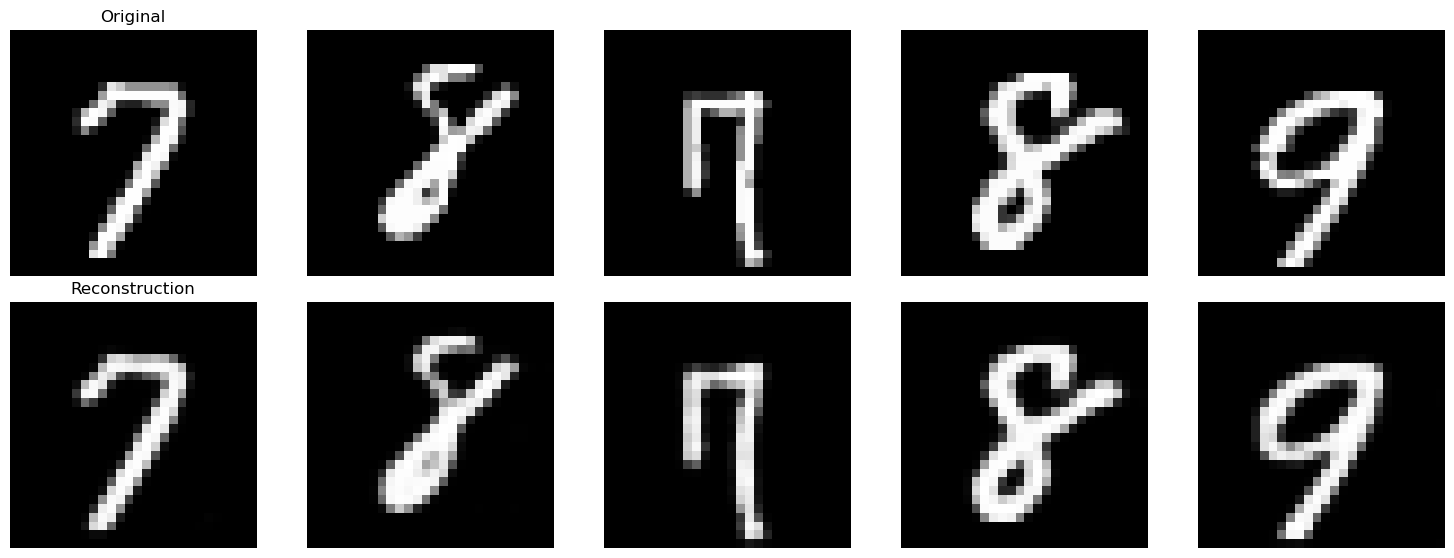

In [19]:
indices = np.random.choice(len(test_dataset), 5, replace=False)

utils.showReconstructions(model, test_dataset, device, indices)


### Self-Supervised MNIST: Linear Interpolation


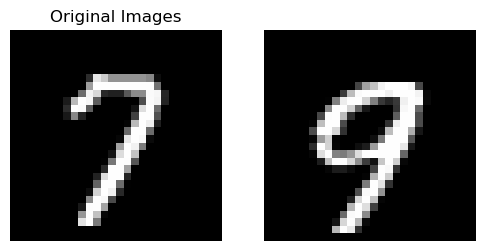

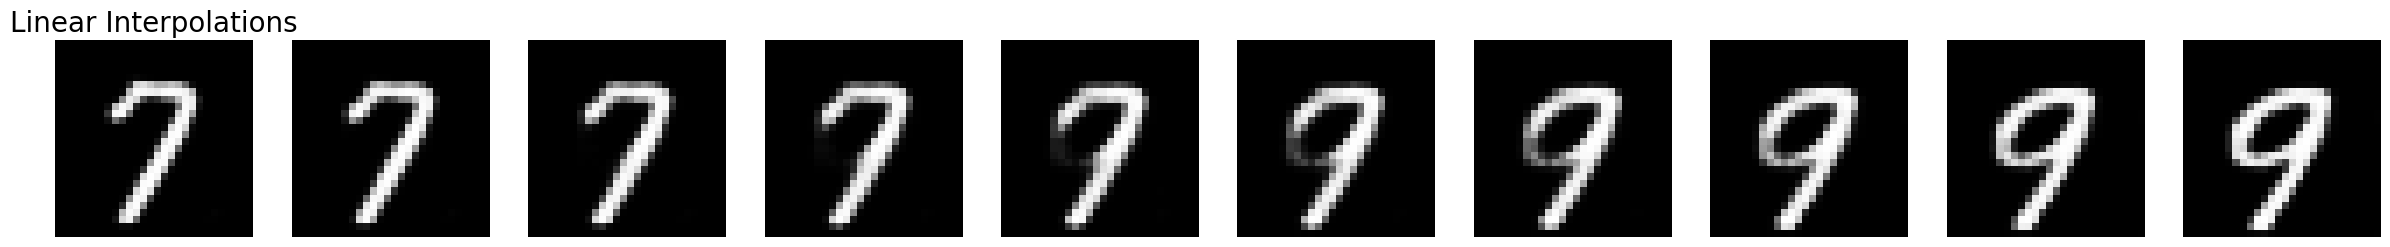

In [20]:
utils.displayInterpolation(model, test_dataset, device, indices[0], indices[4])

### Self-Supervised MNIST: t-SNE 

In [21]:

utils.plot_tsne(model.encoder, dl_test, device)

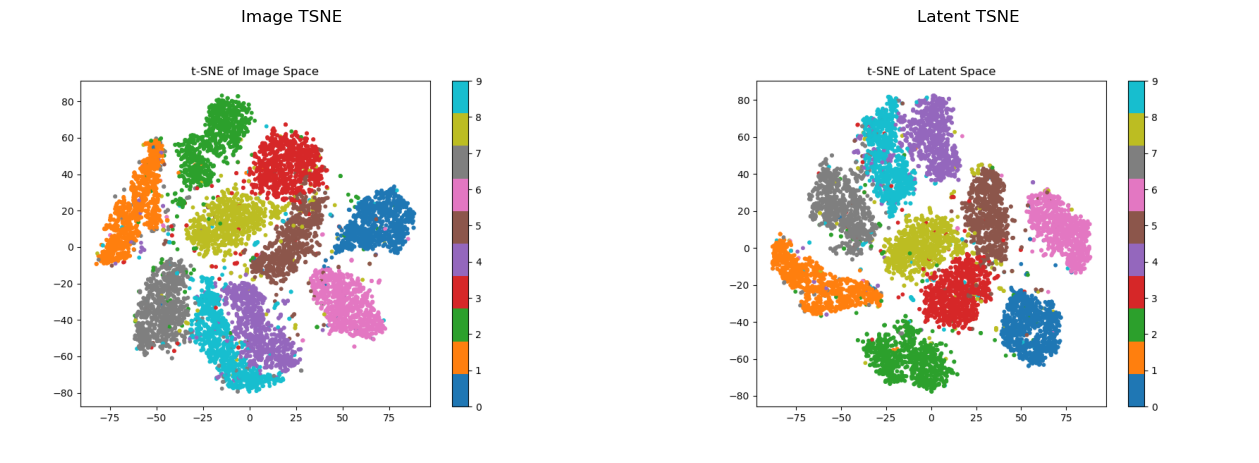

In [22]:
utils.display_tsne()


In [23]:
encoder = models.SelfSupervised_MNIST(latent_dim=128).encoder
encoder.load_state_dict(torch.load("encoder_mnist.pth"))
encoder.to(device)
encoder.eval()  

classifier = models.Classifier(latent_dim=128, num_classes=10).to(device)
fn_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

checkpoints_path = "classifier_mnist.pth"
trainer = training.ClassifierTrainer(classifier, encoder, dl_train, dl_val, fn_loss, optimizer, device)
trainer.train(num_epochs=10, checkpoints=checkpoints_path)

Epoch [1/10], Loss: 0.3773, Accuracy: 89.70, Validation Accuracy: 95.42 %
Epoch [2/10], Loss: 0.1788, Accuracy: 94.73, Validation Accuracy: 96.56 %
Epoch [3/10], Loss: 0.1472, Accuracy: 95.73, Validation Accuracy: 97.16 %
Epoch [4/10], Loss: 0.1276, Accuracy: 96.18, Validation Accuracy: 97.28 %
Epoch [5/10], Loss: 0.1163, Accuracy: 96.53, Validation Accuracy: 97.28 %
Epoch [6/10], Loss: 0.1059, Accuracy: 96.75, Validation Accuracy: 97.50 %
Epoch [7/10], Loss: 0.0987, Accuracy: 97.00, Validation Accuracy: 97.58 %
Epoch [8/10], Loss: 0.0949, Accuracy: 97.15, Validation Accuracy: 97.83 %
Epoch [9/10], Loss: 0.0898, Accuracy: 97.31, Validation Accuracy: 97.82 %
Epoch [10/10], Loss: 0.0839, Accuracy: 97.46, Validation Accuracy: 97.78 %


### Classification-Guided MNIST

In [24]:
model = models.ClassificationGuided_MNIST().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()
trainer = training.ClassificationGuidedTrainer(model,  dl_train, dl_val, dl_test, loss_fn, optimizer, device)
checkpoints_path = "guided_mnist.pth"

trainer.train(num_epochs=10, checkpoints=checkpoints_path)

Epoch [1/10], Loss: 0.4123, Accuracy: 87.26, Validation Accuracy: 95.16%
Epoch [2/10], Loss: 0.1098, Accuracy: 96.76, Validation Accuracy: 97.04%
Epoch [3/10], Loss: 0.0692, Accuracy: 97.88, Validation Accuracy: 97.74%
Epoch [4/10], Loss: 0.0509, Accuracy: 98.42, Validation Accuracy: 98.31%
Epoch [5/10], Loss: 0.0373, Accuracy: 98.82, Validation Accuracy: 97.99%
Epoch [6/10], Loss: 0.0292, Accuracy: 99.06, Validation Accuracy: 98.31%
Epoch [7/10], Loss: 0.0231, Accuracy: 99.22, Validation Accuracy: 98.27%
Epoch [8/10], Loss: 0.0174, Accuracy: 99.44, Validation Accuracy: 98.10%
Epoch [9/10], Loss: 0.0146, Accuracy: 99.52, Validation Accuracy: 98.45%
Epoch [10/10], Loss: 0.0134, Accuracy: 99.55, Validation Accuracy: 98.32%


### Classification-Guided MNIST: t-SNE

In [25]:
utils.plot_tsne(model.encoder, dl_test, device)

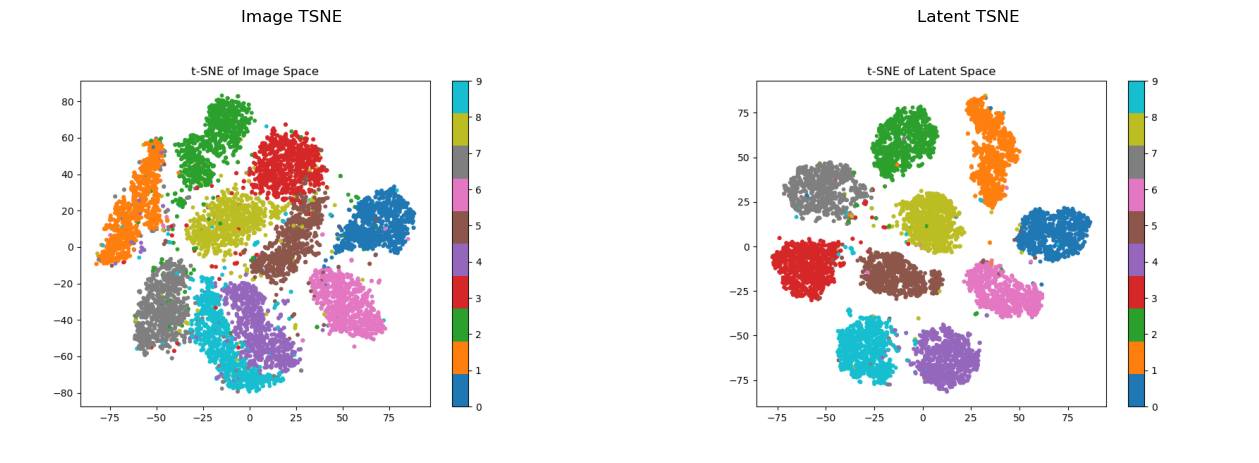

In [26]:
utils.display_tsne()


### Self-Supervised CIFAR10

In [41]:
# CIFAR10 TRAINING
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=False)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=False)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
model = models.SelfSupervised_CIFAR10(latent_dim=128)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

checkpoints_path = "encoder_cifar10.pth"
trainer = training.SelfSupervisedTrainer(model, dl_train, dl_val, loss_fn, optimizer, device, scheduler)
trainer.train(num_epochs=20, checkpoints=checkpoints_path)

Epoch [1/20], Train Loss: 0.0260, Val Loss: 0.0109
Epoch [2/20], Train Loss: 0.0087, Val Loss: 0.0072
Epoch [3/20], Train Loss: 0.0065, Val Loss: 0.0061
Epoch [4/20], Train Loss: 0.0056, Val Loss: 0.0055
Epoch [5/20], Train Loss: 0.0052, Val Loss: 0.0052
Epoch [6/20], Train Loss: 0.0051, Val Loss: 0.0050
Epoch [7/20], Train Loss: 0.0050, Val Loss: 0.0050
Epoch [8/20], Train Loss: 0.0049, Val Loss: 0.0049
Epoch [9/20], Train Loss: 0.0049, Val Loss: 0.0049
Epoch [10/20], Train Loss: 0.0048, Val Loss: 0.0050
Epoch [11/20], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [12/20], Train Loss: 0.0047, Val Loss: 0.0047
Epoch [13/20], Train Loss: 0.0046, Val Loss: 0.0047
Epoch [14/20], Train Loss: 0.0046, Val Loss: 0.0047
Epoch [15/20], Train Loss: 0.0046, Val Loss: 0.0047
Epoch [16/20], Train Loss: 0.0046, Val Loss: 0.0047
Epoch [17/20], Train Loss: 0.0046, Val Loss: 0.0048
Epoch [18/20], Train Loss: 0.0046, Val Loss: 0.0047
Epoch [19/20], Train Loss: 0.0045, Val Loss: 0.0047
Epoch [20/20], Train 

### Self-Supervised CIFAR10: Reconstruction Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


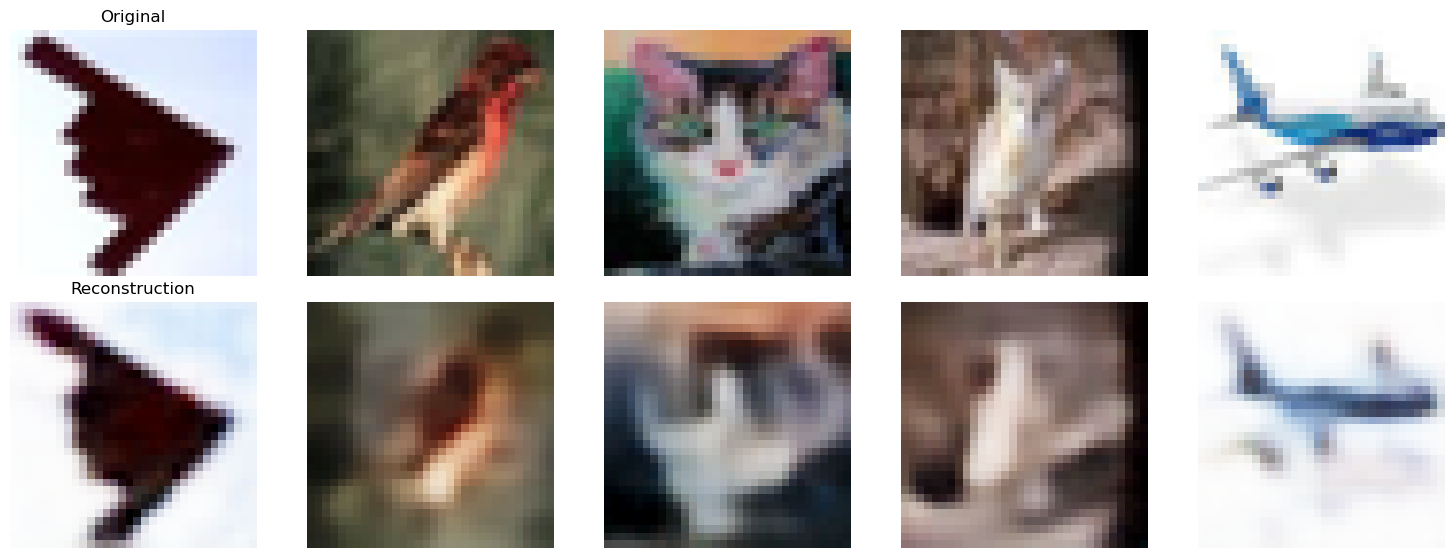

In [46]:

indices = np.random.choice(len(test_dataset), 5, replace=False)

utils.showReconstructions(model, test_dataset, device, indices)

In [47]:
encoder = models.SelfSupervised_CIFAR10(latent_dim=128).encoder
encoder.load_state_dict(torch.load("encoder_cifar10.pth"))
encoder.to(device)
encoder.eval()  

classifier = models.Classifier(latent_dim=128, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


transform = transforms.Compose([transforms.ToTensor()])

checkpoints_path = "classifier_cifar10.pth"
trainer = training.ClassifierTrainer(classifier, encoder, dl_train, dl_test, criterion, optimizer, device, scheduler)
trainer.train(num_epochs=30, checkpoints=checkpoints_path)

Epoch [1/30], Loss: 1.7807, Accuracy: 36.21, Validation Accuracy: 44.81 %
Epoch [2/30], Loss: 1.6041, Accuracy: 42.81, Validation Accuracy: 48.43 %
Epoch [3/30], Loss: 1.5363, Accuracy: 45.47, Validation Accuracy: 49.33 %
Epoch [4/30], Loss: 1.4922, Accuracy: 46.84, Validation Accuracy: 50.35 %
Epoch [5/30], Loss: 1.4542, Accuracy: 48.47, Validation Accuracy: 51.61 %
Epoch [6/30], Loss: 1.4277, Accuracy: 49.35, Validation Accuracy: 52.68 %
Epoch [7/30], Loss: 1.4025, Accuracy: 50.33, Validation Accuracy: 52.14 %
Epoch [8/30], Loss: 1.3853, Accuracy: 50.97, Validation Accuracy: 53.42 %
Epoch [9/30], Loss: 1.3680, Accuracy: 51.30, Validation Accuracy: 53.53 %
Epoch [10/30], Loss: 1.3535, Accuracy: 51.84, Validation Accuracy: 54.22 %
Epoch [11/30], Loss: 1.3022, Accuracy: 53.76, Validation Accuracy: 55.24 %
Epoch [12/30], Loss: 1.2815, Accuracy: 54.50, Validation Accuracy: 55.30 %
Epoch [13/30], Loss: 1.2741, Accuracy: 55.34, Validation Accuracy: 55.84 %
Epoch [14/30], Loss: 1.2625, Accur

### Self-Supervised CIFAR10: t-SNE 

In [48]:
utils.plot_tsne(model.encoder, dl_test, device)

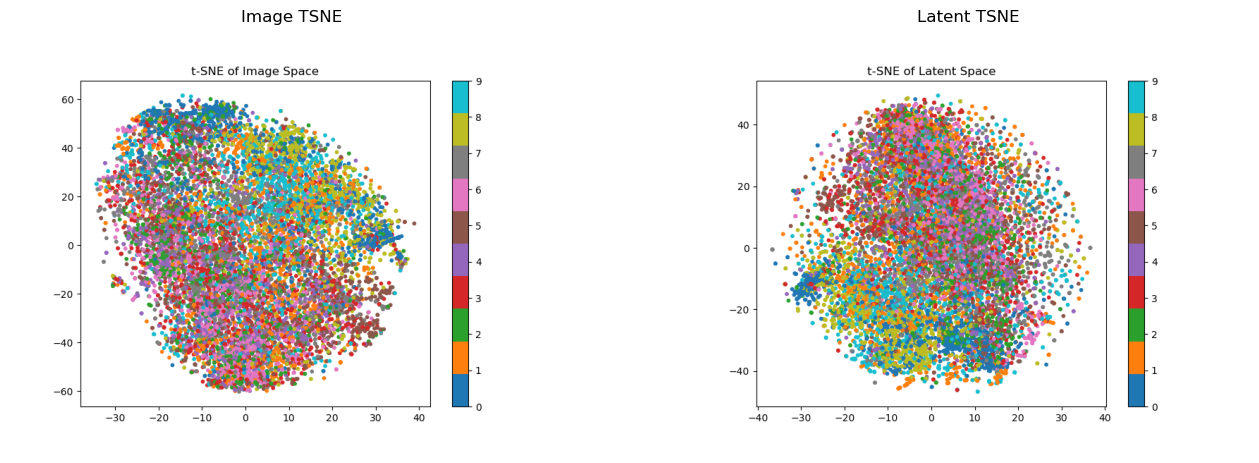

In [49]:
utils.display_tsne()

### Classification-Guided CIFAR10

In [6]:

model = models.ClassificationGuided_CIFAR10().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_fn = nn.CrossEntropyLoss()
trainer = training.ClassificationGuidedTrainer(model,  dl_train, dl_val, dl_test, loss_fn, optimizer, device)
checkpoints_path = "guided_cifar10.pth"

trainer.train(num_epochs=50, checkpoints=checkpoints_path)

Epoch [1/50], Loss: 1.7646, Accuracy: 35.86, Validation Accuracy: 47.58%
Epoch [2/50], Loss: 1.4434, Accuracy: 47.74, Validation Accuracy: 52.64%
Epoch [3/50], Loss: 1.3266, Accuracy: 52.43, Validation Accuracy: 57.20%
Epoch [4/50], Loss: 1.2378, Accuracy: 56.11, Validation Accuracy: 59.52%
Epoch [5/50], Loss: 1.1725, Accuracy: 58.90, Validation Accuracy: 60.16%
Epoch [6/50], Loss: 1.1120, Accuracy: 61.15, Validation Accuracy: 62.72%
Epoch [7/50], Loss: 1.0732, Accuracy: 62.68, Validation Accuracy: 65.26%
Epoch [8/50], Loss: 1.0388, Accuracy: 63.86, Validation Accuracy: 65.10%
Epoch [9/50], Loss: 1.0092, Accuracy: 65.11, Validation Accuracy: 66.80%
Epoch [10/50], Loss: 0.9849, Accuracy: 65.76, Validation Accuracy: 66.54%
Epoch [11/50], Loss: 0.9595, Accuracy: 66.98, Validation Accuracy: 67.26%
Epoch [12/50], Loss: 0.9388, Accuracy: 67.56, Validation Accuracy: 68.18%
Epoch [13/50], Loss: 0.9195, Accuracy: 68.32, Validation Accuracy: 68.70%
Epoch [14/50], Loss: 0.9093, Accuracy: 68.68, V

### Classification-Guided CIFAR10: t-SNE

In [7]:
utils.plot_tsne(model.encoder, dl_test, device)

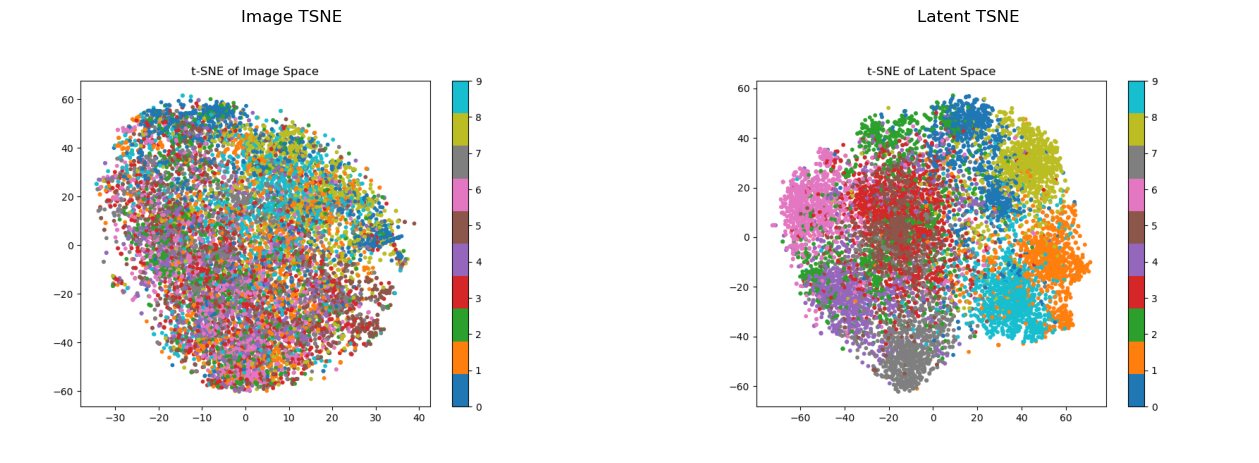

In [8]:
utils.display_tsne()